## Imports

In [1]:
# Import some "default" libraries
# You can now use Pandas to manipulate the Dataframe conveniently

''' Data manipulation'''
import numpy as np
import pandas as pd

''' Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns

# 🚀 Emlak - Gelişmiş Tahminleyici


❗️ Önceki görevde, veri setimizdeki daire sayısı ($\large n$ gözlem $\large> p$ özellik) özellik sayısından fazla olduğunda $\large \boldsymbol X \cdot \boldsymbol \theta = \boldsymbol y $ denklemini "çözemedik". $\large \boldsymbol \theta$ için deterministik bir formül olmadan, yeni dairelerin fiyatlarını tahmin edemezdik!


----


🎯 Bu alıştırmada artık 1000 daireden oluşan daha büyük bir veri setine erişimimiz var ve daha öncekiyle aynı yeni daire için tahminimizi geliştirmek istiyoruz:


- `Surface`: 3000 $ft^2$


- `Bedrooms`: 5 
- `Floors`: 1


❌ $\large \boldsymbol X \cdot \boldsymbol \theta = \boldsymbol y $ denklemini, şekli $ (1000,4)$ olan **`terslenemez`** bir matris $\large \boldsymbol X$ ile çözmek yerine...


🚀 ...$\large {\boldsymbol \theta} = \begin{bmatrix}

     \theta_0 \\

     \theta_1 \\

    \theta_2 \\

     \theta_3

\end{bmatrix}_{4 \times 1}$ vektörünü, hata $ \large \boldsymbol e = \boldsymbol X \cdot \hat{\boldsymbol \theta} - \boldsymbol y  $ en küçük olacak şekilde bulacağız.


Bu bir **`Doğrusal Regresyon Modeli`**dir. Hata $\boldsymbol e$'yi Öklidyen mesafe $\large \left\|\boldsymbol e\right\|$ ve **`Ortalama Kare Hata (MSE)`** ile ölçeceğiz.


👉 $\large \hat{\boldsymbol \theta}$ değerini hesaplayarak yeni dairenin fiyatına yaklaşık bir tahmin bulalım.

## (1) Veri Keşfi


Aşağıda `flats.csv` veri setini yüklüyoruz

In [2]:
flats = pd.read_csv('https://d32aokrjazspmn.cloudfront.net/materials/flats.csv')
flats.head(10)

,price,bedrooms,surface,floors
0,274.0,3,1830,2.0
1,500.0,4,2120,1.0
2,320.0,3,1260,1.0
3,445.5,3,1880,1.0
4,637.5,3,1680,1.0
5,460.0,2,2730,1.0
6,259.0,3,1270,1.5
7,950.0,3,2780,1.0
8,550.0,3,1930,2.0
9,265.5,3,1860,1.0


👀 Fiyatlar hakkında en fazla bilgiyi hangi özelliğin verdiğini görsel olarak anlamak için `sns.scatterplot()` kullanın:

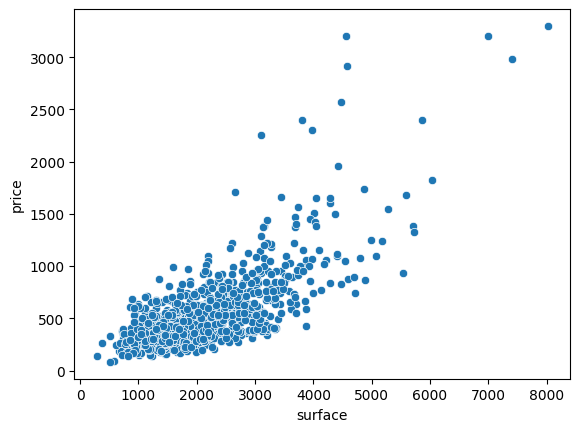

In [3]:
sns.scatterplot(data=flats, x='surface', y='price')
plt.show()

👉 Görünüyor ki `surface` fiyat için yatak odası veya kat sayısından daha güçlü bir gösterge. İstatistikte, `price`'ın diğer özelliklere göre `surface` ile daha **ilişkili** olduğunu söyleriz.


👉 Bunu, DataFrame'deki her sütun çifti arasındaki korelasyon katsayılarını hesaplayan [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) ile kontrol edelim.


<i> <u>Dikkat çekici değerler:</u></i>

* 1: İki sütun tamamen korelasyonlu 📈

* -1: İki sütun tamamen ters korelasyonlu 📉

* 0: İki sütun *doğrusal* olarak korelasyonlu değil 😐

    
<details>
    <summary><i>Korelasyon katsayısı neden kovaryans yerine kullanılır?</i></summary>

✅ <u>Benzerlikler</u>:

    
- 📈 Pozitif korelasyonlar ve pozitif kovaryanslar: X artarsa Y de artar, tersi de geçerli.
- 📉 Negatif korelasyonlar ve negatif kovaryanslar: X artarsa Y azalır, tersi de geçerli.
- 🤔 Sıfır korelasyon ve sıfır kovaryans: 
    - _Doğrusal olarak_ ilişkili değiller, yani $ Y = aX + b$ gibi bir ilişki yok.
    - Ancak $Y = X^{2}$ (kuadratik), $Y = e^{X}$ (üstel), $Y = ln(X)$ (logaritmik), $Y = sin(\sqrt{1+X^7})$ (çok tuhaf) gibi başka ilişkiler olabilir.

❗️<u>Ana farklar</u>:

- 😖 Kovaryans $ cov(X, Y) \in ( - \infty ; + \infty ) $ aralığında olabilir ve karşılaştırmak zordur.
    Örnek: $ cov (X, Y) = 10 $ ve $ cov (X, Z) = 30 $ ise X ve Z daha mı ilişkili? _Hayır_, çünkü birimleri farklı olabilir.

    🧑🏻‍🏫 Çözüm: Korelasyon kullanılır, genellikle $\rho$ harfiyle gösterilir.

👉 <u>Sonuç</u>:

- Korelasyon, kovaryansın standartlaştırılmış halidir: kovaryansı X ve Y'nin standart sapmasına böleriz.
$$ \large  \rho(X,Y) = \frac{cov(X,Y)}{\sigma_X \sigma_Y} \in [0;1]$$

Örnek: $ \rho(X, Y) = 0.80 $ ve $ \rho(X, Z) = 0.15 $ ise, X ve Y daha çok ilişkilidir!
</details>

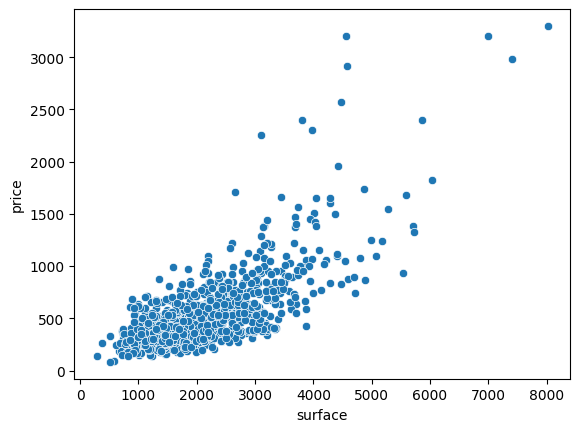

In [9]:
sns.scatterplot(x="surface", y="price", data=flats)
plt.show()

🎨 Bu matrisi hızlıca görmek için [`seaborn.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) ile bir **ısı haritası** kullanabilirsiniz.


<details>
    <summary><i>Daha güzel bir korelasyon matrisi için ipuçları</i></summary>

- `cmap`: **Seaborn** bir görselleştirme kütüphanesi olduğu için, [`cmap`](https://matplotlib.org/stable/tutorials/colors/colormaps.html) argümanını kullanabilirsiniz.
- `annot`: Korelasyon katsayılarını doğrudan renkli harita üzerinde gösterebilirsiniz.
- `annot_kws`: Korelasyon katsayılarının görünümünü özelleştirebilirsiniz.
</details>

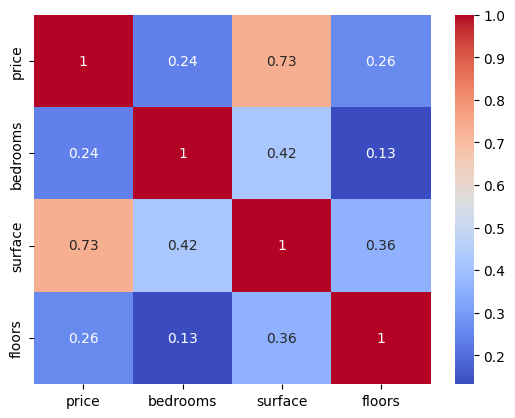

In [4]:
corr_matrix = flats.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

**🧪 Test your code!**

In [5]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'flats',
    shape=flats.shape,
    columns=flats.columns
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tumay/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/tumay/code/data-real-estate-advanced-estimator/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2
collecting ... collected 2 items

test_flats.py::TestFlats::test_columns PASSED                            [ 50%]
test_flats.py::TestFlats::test_shape PASSED                              [100%]

============================== 2 passed in 0.37s ===============================


💯 You can commit your code:

git add tests/flats.pickle

git commit -m 'Completed flats step'

git push origin master



## (2) 1 Özellikli Tahminleyici


Sadece bir özellik olan **surface** ile **price** için istatistiksel bir tahminleyici oluşturalım.


🎯 İki değişken arasında **doğrusal regresyon** kuralım.


Pratikte, $\hat{\boldsymbol \theta}$ = (`eğim`, `kesişim`) parametrelerini öyle seçmek istiyoruz ki, `tahmini fiyat = eğim * surface + kesişim` ifadesi, Ortalama Kare Hata (MSE) açısından `price` değerine en yakın olsun.


📅 Önümüzdeki haftalarda farklı modelleri (Doğrusal Regresyon, KNN, Lojistik Regresyon, Sinir Ağları, vb.) keşfedeceğiz.


👉 Önemli bir işiniz doğru modeli seçmek ve parametreleri optimize ederek en iyi tahminleri yapmaktır.

### (2.1) Görsel Yaklaşım

❓`plot_line(slope, intercept)` fonksiyonunu yazın


Bu fonksiyon, `slope` ve `intercept` argümanları verildiğinde bir `predicted_price` dizisi oluşturur ve bu diziyi orijinal (dağılmış) verinin üstüne çizer.


Fonksiyonu yazdıktan sonra, farklı `(slope, intercept)` değerleriyle oynayarak veriye "iyi bir doğrusal yaklaşım" bulmaya çalışın. En iyi uyumu bulabilir misiniz?


Görsel örnek:


<img src="https://wagon-public-datasets.s3.amazonaws.com/03-Maths/01-Algebra-Calculus/line_of_best_fit.png" width=400>

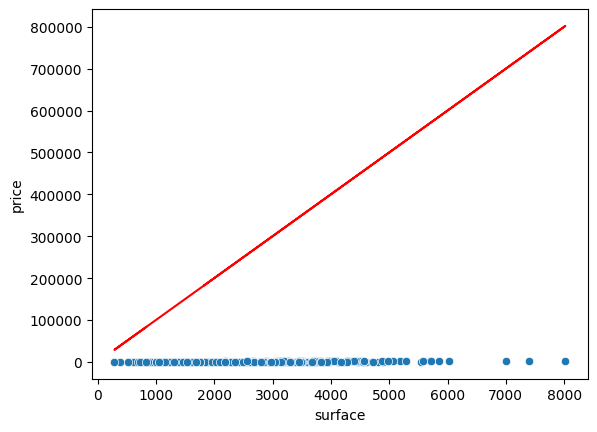

In [10]:
def plot_line(data, slope, intercept):
    x = data['surface']
    
    # Tahmin formülünü yazıyoruz: y = ax + b
    y_pred = slope * x + intercept
    
    # Gerçek verileri nokta olarak, tahminimizi çizgi olarak çiziyoruz
    sns.scatterplot(x="surface", y="price", data=data)
    plt.plot(x, y_pred, color='red') 
    plt.show()

# Şimdi dene: Eğimi 100, kesişimi 10 yaparak bir çizgi çizelim
plot_line(flats, 100, 10)

In [12]:
def plot_line(data, slope, intercept):
    x = data['surface']
    
    # Tahmin formülümüz
    y_pred = slope * x + intercept
    
    # Sadece çizgiyi çiziyoruz, noktaları değil
    plt.plot(x, y_pred, color='red', label=f'Eğim: {slope}')

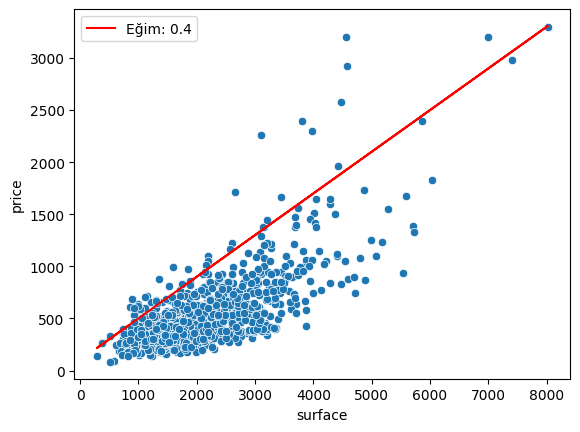

In [13]:
# 1. Önce noktaları çiz
sns.scatterplot(x="surface", y="price", data=flats)

# 2. Şimdi daha mantıklı bir eğimle çizgiyi çiz (Örn: 0.3 veya 0.5)
plot_line(flats, 0.4, 100) 

plt.legend()
plt.show()

Fonksiyonunuzu aşağıdaki hücreyi çalıştırarak test edin, ardından iyi bir en küçük hata doğrusu bulmak için değerleri değiştirin!


*İpucu: Aynı hücrede `plot_line()` fonksiyonunu birden fazla kez çalıştırarak aynı dağılım grafiğinde birden fazla doğru çizebilirsiniz* 😉

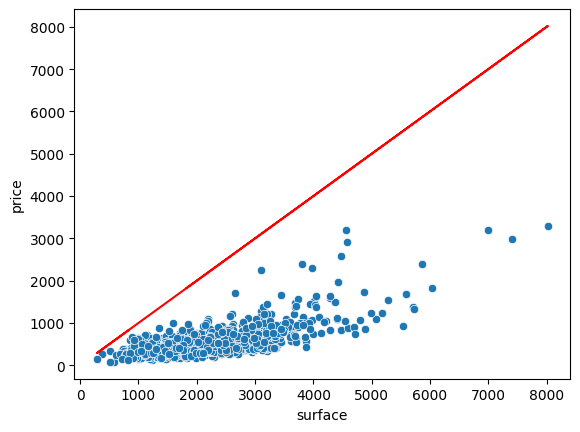

In [14]:
sns.scatterplot(x="surface", y="price", data=flats)
plot_line(flats, 1, 1)

😅 O kadar da kolay (ve çok "bilimsel" değil), değil mi?

### (2.2) Hesaplamalı Yaklaşım


🔥 Tahminleyici doğrunun en iyi olmasını sağlamak için, **gerçek fiyatlar** ile **tahmini fiyatlar** arasındaki **Ortalama Kare Hata**yı (MSE) hesaplamamız gerekir!


👉 Unutmayın:


- Her daire için `tahmini_fiyat = eğim * surface + kesişim`


- Hem **gerçek fiyat vektörü** hem de **tahmini fiyat vektörü** $ (1000, 1)$ boyutunda

#### (2.2.1) Kare Hatalar

<u><b>Adım 1</b></u>


❓Her satır (_yani daire_) için `squared_error = (price - predicted_price)**2` hesaplamalıyız❓

In [15]:
def compute_squared_errors(slope, intercept, surfaces, prices):
    """
    Bu fonksiyon her bir daire için hata payının karesini hesaplar.
    """
    # 1. Önce senin çizginden gelen tahmini fiyatı hesapla (y_pred = ax + b)
    predictions = slope * surfaces + intercept
    
    # 2. Gerçek fiyat ile tahmin arasındaki farkın karesini al
    # Kare alıyoruz çünkü hata negatif çıksa bile pozitif bir maliyet olarak görünsün.
    squared_errors = (prices - predictions)**2
    
    return squared_errors

💡 Veri Bilimi/Modelleme'de genel bir ilke: $ \large error = f(\boldsymbol y, \hat{\boldsymbol y})$ burada:


- $ \large \boldsymbol y $ gerçek değer


- $ \large \hat{\boldsymbol y} $ tahmini değer


- $ \large f$ genellikle **Kayıp Fonksiyonu** veya **Maliyet Fonksiyonu** olarak adlandırılır 
    - 📆 `Makine Öğrenmesi I > Model Ayarı`

#### (2.2.2) Ortalama Kare Hata (MSE)

<u><b>Adım 2</b></u>


❓ `mse` fonksiyonunu oluşturun, bu fonksiyon `squared_errors` fonksiyonundan dönen dizinin ortalamasını döndürmeli. ❓

In [16]:
def compute_mse(slope, intercept, surfaces, prices):
    # Önce yukarıda yazdığımız fonksiyonu kullanarak tüm hataları hesapla
    errors = compute_squared_errors(slope, intercept, surfaces, prices)
    
    # Bu hataların ortalamasını (mean) al ve döndür
    return errors.mean()

👉 _(2.1) Görsel yaklaşım_ bölümünde, "en iyi doğruyu" yani en iyi `(slope, intercept)` çiftini görsel olarak tahmin etmeye çalıştınız.


❓Bu "en iyi çifti" kullanarak tahminleyicinizin MSE'sini hesaplayın. ❓

In [17]:
# Veri setindeki sütunları değişkenlere atayalım
surfaces = flats['surface']
prices = flats['price']

# Senin görsel olarak bulduğun değerlerle hata puanını hesapla
hata_puanim = compute_mse(0.4, 100, surfaces, prices)
print(f"Senin Çizginin Hata Puanı (MSE): {hata_puanim}")

Senin Çizginin Hata Puanı (MSE): 233922.02900490697


### (2.3) En İyi Parametreleri Bulmak


👉 Farklı `slope` ve `intercept` değerleriyle oynamaya devam edin ve en iyi uyumu elde etmeye çalışın! İki parametreyi aynı anda optimize etmenin ne kadar zor olduğunu fark edin.


👇 Aşağıdaki adımları izleyerek olası bir yaklaşım görebilirsiniz:

#### (2.3.1) En İyi Eğim Değerini Bulmak

<b><i><u> Adım 1 :</u></i></b>


`initial_intercept` için en iyi tahmininizi sabitleyerek başlayın, ardından yaklaşık olarak `mse = f(slope)` fonksiyonunu en aza indiren eğimi bulun

In [ ]:
# Define an initial_intercept, for instance, we may suppose there is always a small transaction fee even for very small flats


In [40]:
# Başlangıç kesişimini sabitleyelim
initial_intercept = 0

# 0 ile 1 arasında 100 farklı eğim oluştur
slopes = np.linspace(0, 1, 100)

# Her bir eğim için MSE değerlerini hesaplayıp bir listeye at
mses = []
for s in slopes:
    mse = compute_mse(s, initial_intercept, surfaces, prices)
    mses.append(mse)

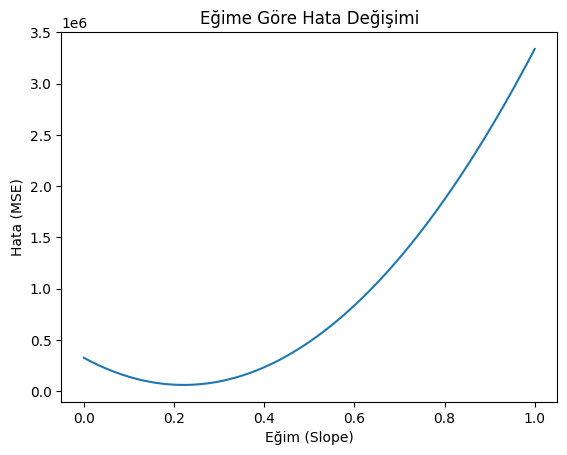

In [19]:
plt.plot(slopes, mses)
plt.xlabel('Eğim (Slope)')
plt.ylabel('Hata (MSE)')
plt.title('Eğime Göre Hata Değişimi')
plt.show()

In [ ]:
# Create a range of 100 slopes that contains what you believe is the optimal slope (hint: np.linspace())


In [20]:
# Listedeki en küçük MSE değerini bul
mse_min = min(mses)

# Bu en küçük değerin listedeki sırasını (indeksini) bul
best_index = mses.index(mse_min)

# O sıradaki eğim değerini çek
slope_best = slopes[best_index]

print(f"En düşük hata: {mse_min}")
print(f"Bunu sağlayan en iyi eğim: {slope_best}")

En düşük hata: 61498.36308569712
Bunu sağlayan en iyi eğim: 0.22222222222222224


In [22]:
# -100 ile 500 arasında denemek için 100 tane kesişim değeri oluştur
intercepts = np.linspace(-100, 500, 100)

In [23]:
mses_intercept = []
for i in intercepts:
    # Bu sefer slope_best sabit, i (intercept) değişken!
    mse = compute_mse(slope_best, i, surfaces, prices)
    mses_intercept.append(mse)

In [24]:
# En düşük MSE'yi bul
mse_min = min(mses_intercept)

# Bu değerin indeksini bul
best_intercept_index = mses_intercept.index(mse_min)

# En iyi kesişim değerini çek
intercept_best = intercepts[best_intercept_index]

print(f"Yeni en düşük hata: {mse_min}")
print(f"Bunu sağlayan en iyi kesişim: {intercept_best}")

Yeni en düşük hata: 60915.00557507575
Bunu sağlayan en iyi kesişim: 75.75757575757575


In [26]:
# Notebook'taki bu hücreyi çalıştır:
regression = smf.ols(formula= 'price ~ surface', data=flats).fit()
print("Gerçek En İyi Kesişim:", regression.params['Intercept'])
print("Gerçek En İyi Eğim:", regression.params['surface'])

NameError: name 'smf' is not defined

In [ ]:
# Create the list of MSEs for each slope value


❓MSE'leri eğimlere karşı çizin. Bir minimum görüyor musunuz❓


🙃 Görmüyorsanız, başka bir eğim aralığı deneyin!

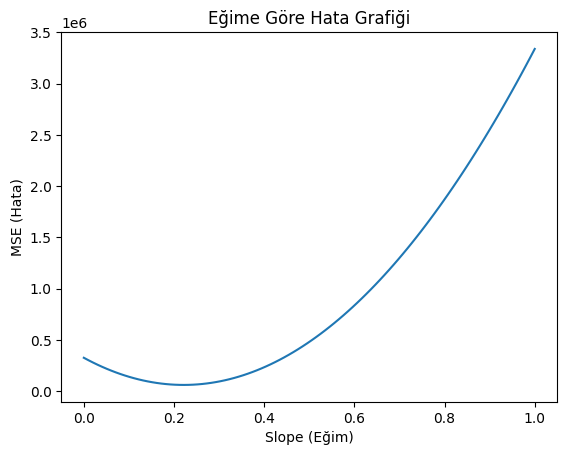

In [27]:
# İlk boş hücre: MSE'leri eğimlere karşı çizme
plt.plot(slopes, mses)
plt.xlabel('Slope (Eğim)')
plt.ylabel('MSE (Hata)')
plt.title('Eğime Göre Hata Grafiği')
plt.show()

❓`initial_intercept` için MSE'nin minimum değerini ve karşılık gelen `slope_best` değerini hesaplayın❓


<details>
    <summary><i>İpucu</i></summary>
    
Burada Python'un yerleşik `.min()` fonksiyonunu ve `List.index()` metodunu kullanabilirsiniz
    
</details>

In [28]:
# İkinci boş hücre: slope_best hesaplama
mse_min = min(mses)
best_index = mses.index(mse_min)
slope_best = slopes[best_index]

print(f"Bunu sağlayan en iyi eğim: {slope_best}")

Bunu sağlayan en iyi eğim: 0.22222222222222224


#### (2.3.2) En İyi Kesişim Değerini Bulmak

<b><i><u> Adım 2 :</u></i></b>


🔨 Şimdi, eğimi `slope_best` değerine sabitleyin ve önceki yaklaşımı tekrar kullanarak "en iyi" `intercept_best` değerini bulun.

In [29]:
# Create a range of 100 intercepts that contains what you believe is the optimal intercept
# Üçüncü boş hücre: Intercept aralığı oluşturma
# En iyi kesişimi bulmak için -100 ile 500 arasında 100 değer deneyelim
intercepts = np.linspace(-100, 500, 100)

In [30]:
# Create the list of MSEs for each intercept value
mses_intercept = []
for i in intercepts:
    # slope_best sabit (0.222), i (intercept) değişiyor
    mse = compute_mse(slope_best, i, surfaces, prices)
    mses_intercept.append(mse)

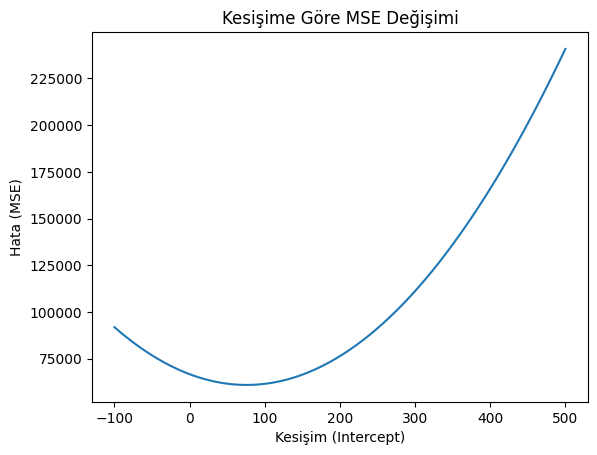

In [31]:
# Plot MSEs against intercepts. Do you see a minimum? If not, try another range of slopes!
plt.plot(intercepts, mses_intercept)
plt.xlabel('Kesişim (Intercept)')
plt.ylabel('Hata (MSE)')
plt.title('Kesişime Göre MSE Değişimi')
plt.show()

❓Eğim `slope_best` olduğunda MSE'lerin minimum değeri olan `mse_min`'i ve karşılık gelen en iyi kesişimi `intercept_best` olarak hesaplayın❓



In [32]:
mse_min = None
intercept_best = None

In [34]:
# Listendeki en küçük MSE değerini ve onun hangi eğime denk geldiğini bul
mse_min = min(mses)
best_index = mses.index(mse_min)
slope_best = slopes[best_index]

print(f"En düşük hata: {mse_min}")
print(f"En iyi eğim: {slope_best}")

En düşük hata: 61498.36308569712
En iyi eğim: 0.22222222222222224


In [35]:
mses_intercept = []
for i in intercepts:
    # Az önce bulduğun slope_best artık sabit, sadece i (intercept) değişiyor
    mse = compute_mse(slope_best, i, surfaces, prices)
    mses_intercept.append(mse)

In [36]:
# Kesişim denemelerindeki en düşük hatayı bul
mse_min = min(mses_intercept)
best_intercept_index = mses_intercept.index(mse_min)
intercept_best = intercepts[best_intercept_index]

print(f"Final Minimum Hata: {mse_min}")
print(f"En İyi Kesişim: {intercept_best}")

Final Minimum Hata: 60915.00557507575
En İyi Kesişim: 75.75757575757575


In [41]:
# Bu hücreyi tekrar çalıştır
mses = []
for s in slopes:
    mse = compute_mse(s, initial_intercept, surfaces, prices)
    mses.append(mse)

slope_best = slopes[mses.index(min(mses))]

In [42]:
# i (intercept) araması yapan hücreyi tekrar çalıştır
mses_intercept = []
for i in intercepts:
    mse = compute_mse(slope_best, i, surfaces, prices)
    mses_intercept.append(mse)

mse_min = min(mses_intercept)
intercept_best = intercepts[mses_intercept.index(mse_min)]

**🧪 Test your code!**

In [43]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'univariate',
    mse_min=mse_min,
    slope_best=slope_best,
    intercept_best=intercept_best
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tumay/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/tumay/code/data-real-estate-advanced-estimator/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2
collecting ... collected 3 items

test_univariate.py::TestUnivariate::test_best_intercept PASSED           [ 33%]
test_univariate.py::TestUnivariate::test_best_slope PASSED               [ 66%]
test_univariate.py::TestUnivariate::test_mse PASSED                      [100%]

============================== 3 passed in 0.15s ===============================


💯 You can commit your code:

git add tests/univariate.pickle

git commit -m 'Completed univariate step'

git push origin master



🎉 **Harika iş**! Sıfır olmayan bir kesişim parametresi ekleyerek MSE'yi daha da azalttık (yaklaşık uyumu görsel olarak doğrulamak için regresyon doğrusunu dağılım grafiğinizde çizebilirsiniz).


❓Peki, bu (`intercept_best`, `slope_best`) parametrelerinin gerçekten en iyi değerler olduğuna ne garanti verir? 

<details>
    <summary>👀 Açıklamalar (<strong>bunu dikkatlice okuyun!</strong>)</summary>


Belki de adım ①'i tekrar ederek, bu sefer kesişimi `intercept_best`'e sabitleyip, ardından adım ②'yi yeni eğimle tekrar ederek daha iyi bir eğim değeri bulabiliriz.


İki parametreli bir fonksiyonun `rmse = f(slope, intercept)` global minimumunu bulmak için, adım ① ve ②'yi sonsuza kadar tekrarlamamız gerekebilir - başarı garantisi olmadan.


<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/decision-science/real-estate-minimizer.png'>


💪 Makine Öğrenmesinin en temel yönlerinden birini keşfettiniz: **minima bulma sürecinin tekrarlılığı**.


👉 Tahmin edebileceğiniz gibi, Veri Bilimi dünyasında bu tür süreçleri otomatikleştiren ve optimize eden algoritmalar geliştirilmiştir. Sonraki ünitelerde, bu tekrarlama işlemini sizin için yapan **Gradient Descent** gibi algoritmaların gücünü keşfedeceksiniz.
</details>

👉 Merak ediyorsanız ve bu veri seti için gerçek en iyi eğim ve kesişimi bulmak istiyorsanız aşağıdaki hücreleri çalıştırın.

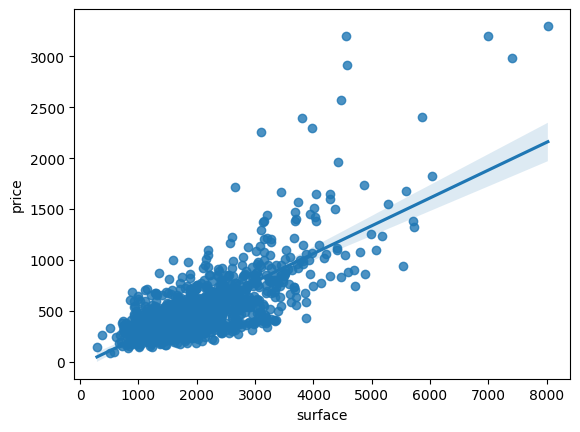

In [38]:
# Try this out (Seaborn visual solution)
sns.regplot(data=flats, x='surface', y='price');

In [39]:
# Try this out (statsmodels, exact solution)!
import statsmodels.formula.api as smf

regression = smf.ols(formula= 'price ~ surface', data=flats).fit()

print("intercept_best", regression.params['Intercept'])
print("slope_best", regression.params['surface'])
print('mse_best: ', np.mean(regression.resid**2))

intercept_best -33.30833598535581
slope_best 0.27369043218689093
mse_best:  58515.12390949639


❓Başlangıç sorumuza geri dönelim: Aşağıdaki 5. daire için yeni tahmininiz nedir? Sadece 4 daireye dayalı ilk tahmininizle nasıl karşılaştırılır?


- `surface`: 3000 $ft^2$


- `bedrooms`: 5 
- `floors`: 1

In [44]:
# Kesin çözümdeki (statsmodels) değerleri kullanarak tahmin yapalım
slope_best_final = 0.27369
intercept_best_final = -33.30833

predicted_price = (slope_best_final * 3000) + intercept_best_final
print(f"3000 sqft daire için tahmin edilen fiyat: {predicted_price}")

3000 sqft daire için tahmin edilen fiyat: 787.76167


☝️ Sadece 4 daireye dayalı ilk deterministik tahminleyicimizden daha iyi, ancak bu tahminde yatak odası ve kat sayısının sağladığı bilgiyi kaçırıyoruz!

## (3) _Tüm_ Özelliklerle Tahminleyici (`surface`, `bedrooms`, `floors`)?

💡 Üç özellikli bir doğrusal regresyon (**Çok Değişkenli Doğrusal Regresyon**) tek özellikliyle aynı şekilde çalışır, ancak RMSE'yi en aza indirmek için sadece 2 parametre değil, 4 parametre bulmamız gerekir: $\hat{\boldsymbol \theta}$ = (`intercept`, `slope_surface`, `slope_bedrooms`, `slope_floors`).


🗓 Bu **Çok Değişkenli Doğrusal Regresyon**u **Karar Bilimi** modülünde daha ayrıntılı inceleyeceğiz.


🗓 Kapalı analitik çözümle (bir sonraki bölümde göreceksiniz) Ordinary Least Squares regresyonu hesaplanabilir, ancak hesaplama açısından çok karmaşık olabilir.


🗓 Bu yüzden genellikle yukarıda bahsedilen **Gradient Descent** gibi yinelemeli yöntemler kullanılır. Makine Öğrenmesinde çok güçlü ve önemli bir yöntemdir ve bootcamp'te kendiniz kodlayacaksınız.


👉 Bu arada, aşağıdaki hücreyi çalıştırarak bu çok değişkenli regresyonun nihai sonucunu görebilirsiniz:

In [45]:
# Find the four regression coefficients by running this cell
regression = smf.ols(formula= 'price ~ surface + bedrooms + floors', data=flats).fit()
regression.params

Intercept    18.154854
surface       0.286953
bedrooms    -21.623564
floors       -3.811868
dtype: float64

🎉 Artık en iyi parametreleri bulduğumuza göre $\boldsymbol {\hat \theta}= \begin{bmatrix}

     \theta_0 \\

     \theta_1 \\

    \theta_2 \\

     \theta_3 \\

\end{bmatrix}_{4 \times 1} = 
\begin{bmatrix}

     \theta_{intercept} \\

     \theta_{surface}\\

    \theta_{bedrooms} \\

     \theta_{floors}

\end{bmatrix}_{4 \times 1} = 
\begin{bmatrix}

    18.154854 \\

    0.286953 \\

    -21.623564 \\

    -3.811868

\end{bmatrix}_{4 \times 1}

$, 


yeni dairenin fiyatını tahmin edebiliriz:

* $3000 ft^2$

* $5$ yatak odası

* $1.$ katta


$$ \hat{y_5} = \theta_0 + \theta_1 \times 3000 + \theta_2 \times 5 + \theta_3 \times 1 $$

In [ ]:
# Compute the newly predicted price for the 5th flat? Is this prediction better?
pass  # YOUR CODE HERE

In [46]:
# surface: 3000 kullanarak tahmin yapalım
predicted_price_univariate = (0.273690 * 3000) - 33.30833
print(f"Sadece yüz ölçümü ile tahmin: {predicted_price_univariate}")

Sadece yüz ölçümü ile tahmin: 787.76167


In [47]:
# Çok değişkenli formül: y = t0 + t1*surface + t2*bedrooms + t3*floors
t0, t1, t2, t3 = 18.154854, 0.286953, -21.623564, -3.811868

final_prediction = t0 + (t1 * 3000) + (t2 * 5) + (t3 * 1)
print(f"Tüm özelliklerle geliştirilmiş tahmin: {final_prediction}")

Tüm özelliklerle geliştirilmiş tahmin: 767.0841660000001


## (4) Concluding Remarks on Linear Algebra 🧠

Bu **optimizasyon problemi** şöyle özetlenebilir:


- $\hat{\boldsymbol \theta} = \begin{bmatrix}

     \theta_{intercept} \\

     \theta_{surface}\\

    \theta_{bedrooms} \\

     \theta_{floors}

\end{bmatrix}_{4 \times 1}$ vektörünü bulmamız gerekir.


- $e = \left\|\boldsymbol X\cdot \hat{\boldsymbol \theta} - \boldsymbol y  \right\|^2$ hatasını en küçük yapanı bulmamız gerekir.


- Özellikler matrisi $\boldsymbol X$ [sabit, surfaces, floors, bedrooms]  $\begin{bmatrix}

    1 & 620 & 1 & 1 \\

    1 & 3280 & 4 & 2 \\

    ... \\

    1 & 1900 & 2 & 2 \\

    1 & 1320 & 3 & 3

   \end{bmatrix}_{n \times 4}

$


- ve gözlem vektörü $\boldsymbol y  = \begin{bmatrix}

           y_{1} \\

           y_{2} \\

           \vdots \\

           y_{1000}

         \end{bmatrix}$ (fiyatlar)


Böyle bir $\large \hat{\theta}$, $ \large 2 \boldsymbol X^T\cdot (\boldsymbol X \cdot \hat{\theta}−\boldsymbol y )$ türevleri sıfır olduğunda elde edilir (👉 ispatı Karar Bilimi modülündeki Doğrusal Regresyon dersinde bulabilirsiniz). 
    
Başka bir deyişle, $\large (\boldsymbol X^T\cdot \boldsymbol X)\cdot \hat{\boldsymbol \theta}=\boldsymbol X^T \cdot \boldsymbol y $ doğrusal sistemini çözmemiz gerekir. 
    
Bu doğrusal sistemin tek bir çözümü vardır, eğer $\boldsymbol X$'in hiçbir sütunu diğerlerinin doğrusal birleşimiyle ifade edilemiyorsa: bu durumda $ \large (\boldsymbol X^T \cdot \boldsymbol X)^{-1}$ terslenebilirdir ve minimum $\large \hat{\boldsymbol \theta} = (\boldsymbol X^T\cdot \boldsymbol X)^{-1} \cdot \boldsymbol X^T \cdot \boldsymbol y $ ile elde edilir. Dikkat edin, $\boldsymbol X$ artık ilk görevdeki gibi kare olmak zorunda değil 💪.


💥 Ancak, **matrisleri terslemek hesaplama açısından karmaşıktır**. Bu yüzden bir fonksiyonun minimumunu bulmak için başka yöntemler geliştirilmiştir, örneğin **Gradient Descent**.
    
📚 Daha fazla bilgi için [Stats.StackExchange](https://stats.stackexchange.com/a/278779) adresini inceleyin!
</details>

🏁 Tebrikler! 


💾 Not defterinizi `git add/commit/push` ile kaydetmeyi unutmayın!